# VR Mini Project - Segmentation Tasks

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
import random


In [ ]:
# Set image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 16
EPOCHS = 40

# Path to dataset
IMAGE_DIR = "/dataset/dataset2/images"
MASK_DIR = "/dataset/dataset2/mask"


## Part C : Segmentation using traditional Techniques - Watersheding

In [ ]:
# Background removal using thresholding + edge detection

def remove_background_high_contrast(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    edges = cv2.Canny(gray, 50, 150)
    combined = cv2.bitwise_or(thresh, edges)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask_color = cv2.inRange(hsv, np.array([80, 30, 30]), np.array([130, 255, 255]))
    combined = cv2.bitwise_or(combined, mask_color)
    kernel = np.ones((3, 3), np.uint8)
    refined = cv2.morphologyEx(cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, 2), cv2.MORPH_OPEN, kernel, 1)
    contours, _ = cv2.findContours(refined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask_foreground = np.zeros_like(gray)
    if contours:
        cv2.drawContours(mask_foreground, [max(contours, key=cv2.contourArea)], -1, 255, thickness=cv2.FILLED)
    mask_foreground = cv2.morphologyEx(mask_foreground, cv2.MORPH_CLOSE, kernel, 1)
    return cv2.merge([*cv2.split(cv2.bitwise_and(image, image, mask=mask_foreground)), mask_foreground])

# Background removal using GrabCut

def remove_background(image):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    bgdModel, fgdModel = np.zeros((1, 65), np.float64), np.zeros((1, 65), np.float64)
    rect = (10, 10, image.shape[1] - 20, image.shape[0] - 20)
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    new_mask = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD), 0, 1).astype("uint8")
    new_mask = cv2.dilate(new_mask, np.ones((5, 5), np.uint8), iterations=1)
    return cv2.merge([*cv2.split(image * new_mask[:, :, np.newaxis]), new_mask * 255])

# Process images in a directory

def process_images(images_dir, masks_dir, num_images=10, random_select=False):
    image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))])
    selected_files = random.sample(image_files, min(num_images, len(image_files))) if random_select else image_files[:num_images]
    results = []
    for filename in selected_files:
        image, gt_mask = cv2.imread(os.path.join(images_dir, filename)), cv2.imread(os.path.join(masks_dir, filename), cv2.IMREAD_GRAYSCALE)
        if image is None or gt_mask is None:
            continue
        print(f"Processing: {filename}")
        results.append((filename, image, remove_background(image), gt_mask))
    return results

# Watershed segmentation

def apply_watershed(processed_img):
    if processed_img.shape[2] == 4:
        image_bgr = cv2.merge([*cv2.split(processed_img)[:3]])
    else:
        image_bgr = processed_img.copy()
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    binary = cv2.morphologyEx(cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8)), cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    markers = np.zeros_like(gray, dtype=np.int32)
    markers[binary == 0] = 1
    markers[:int(gray.shape[0] * 0.4), :][binary[:int(gray.shape[0] * 0.4), :] > 0] = 2
    markers[int(gray.shape[0] * 0.4):, :][binary[int(gray.shape[0] * 0.4):, :] > 0] = 3
    cv2.watershed(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB), markers)
    watershed_result = np.where(markers == 3, 255, 0).astype(np.uint8)
    mask_colored = np.zeros_like(image_bgr)
    mask_colored[watershed_result == 255] = [255, 255, 255]
    return mask_colored, watershed_result

# IoU computation

def compute_iou(mask1, mask2, threshold=127):
    mask1_bin, mask2_bin = cv2.threshold(mask1, threshold, 255, cv2.THRESH_BINARY)[1], cv2.threshold(mask2, threshold, 255, cv2.THRESH_BINARY)[1]
    intersection, union = np.logical_and(mask1_bin == 255, mask2_bin == 255), np.logical_or(mask1_bin == 255, mask2_bin == 255)
    return np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0.0

# Process images and display results

images_dir, masks_dir = "dataset_2/images", "dataset_2/mask"
results, iou_list = process_images(images_dir, masks_dir, num_images=10), []
for filename, original, processed, gt_mask in results:
    mask_colored, watershed_result = apply_watershed(processed)
    if gt_mask.shape != watershed_result.shape:
        gt_mask = cv2.resize(gt_mask, (watershed_result.shape[1], watershed_result.shape[0]), interpolation=cv2.INTER_NEAREST)
    iou_val = compute_iou(watershed_result, gt_mask)
    print(f"IoU for {filename}: {iou_val:.4f}")
    iou_list.append(iou_val)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)), plt.title(f"Original: {filename}"), plt.axis('off')
    plt.subplot(1, 2, 2), plt.imshow(mask_colored), plt.title(f"Watershed Segmentation\nIoU: {iou_val:.4f}"), plt.axis('off')
    plt.tight_layout(), plt.show()
print(f"Average IoU: {sum(iou_list) / len(iou_list):.4f}" if iou_list else "No IoU values computed.")


## Part D: Segmentation using UNET

In [35]:
# Load images and masks
def load_data(image_dir, mask_dir, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))  # Ensure correct order
    mask_files = sorted(os.listdir(mask_dir))

    count = 0

    for img_file, mask_file in zip(image_files, mask_files):
        if(count>=700):
            break
        # Read and resize images
        img = cv2.imread(os.path.join(image_dir, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, img_size) / 255.0  # Normalize

        # Read and resize masks
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        mask = mask / 255.0  # Convert to binary (0 or 1)

        images.append(img)
        masks.append(mask)
        count+=1
    return np.array(images), np.array(masks)

# Load dataset
X, Y = load_data(IMAGE_DIR, MASK_DIR)
print(f"Dataset loaded: {X.shape}, {Y.shape}")

Dataset loaded: (700, 128, 128, 3), (700, 128, 128, 1)


In [ ]:

# Define U-Net Model
def unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

def dice_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)


X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
model = unet()
model.compile(optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=[iou_metric,dice_metric])

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

model.save("unet_mask_segmentation.h5")

Epoch 1/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 324ms/step - dice_metric: 0.0596 - iou_metric: 0.0404 - loss: 0.8552 - val_dice_metric: 0.6992 - val_iou_metric: 0.5405 - val_loss: 0.5511
Epoch 2/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - dice_metric: 0.5575 - iou_metric: 0.4004 - loss: 0.5432 - val_dice_metric: 0.6912 - val_iou_metric: 0.5337 - val_loss: 0.4218
Epoch 3/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - dice_metric: 0.6113 - iou_metric: 0.4552 - loss: 0.5132 - val_dice_metric: 0.7874 - val_iou_metric: 0.6506 - val_loss: 0.3465
Epoch 4/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - dice_metric: 0.6745 - iou_metric: 0.5182 - loss: 0.5172 - val_dice_metric: 0.7620 - val_iou_metric: 0.6197 - val_loss: 0.3127
Epoch 5/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - dice_metric: 0.8053 - iou_metric: 0.6753 - loss: 0.3036 - val_dice_metric: 0.8353 - val_iou_metric: 0.7174 - val_loss: 0.2622
Epoch 6/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - dice_metric: 0.8323 - iou_metric: 0.7139 

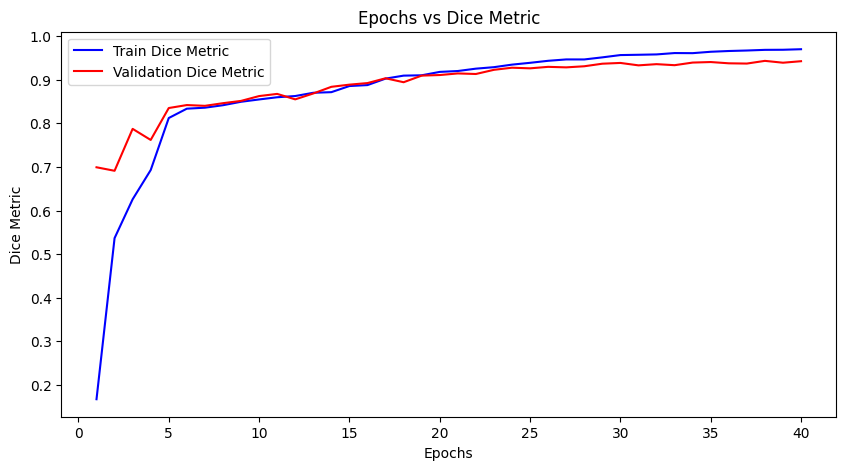

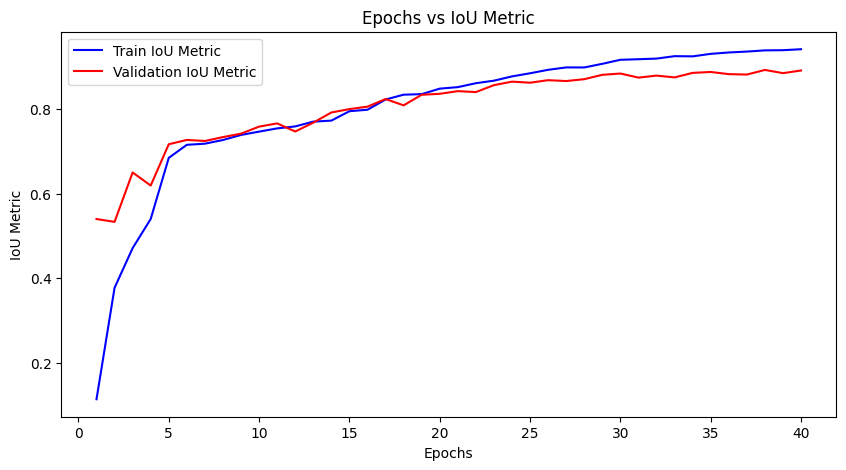

In [ ]:
epochs = range(1, len(history.history['dice_metric']) + 1)
dice_train = history.history['dice_metric']
dice_val = history.history['val_dice_metric']
iou_train = history.history['iou_metric']
iou_val = history.history['val_iou_metric']

plt.figure(figsize=(10, 5))
plt.plot(epochs, dice_train, 'b-', label='Train Dice Metric')
plt.plot(epochs, dice_val, 'r-', label='Validation Dice Metric')
plt.xlabel('Epochs')
plt.ylabel('Dice Metric')
plt.title('Epochs vs Dice Metric')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, iou_train, 'b-', label='Train IoU Metric')
plt.plot(epochs, iou_val, 'r-', label='Validation IoU Metric')
plt.xlabel('Epochs')
plt.ylabel('IoU Metric')
plt.title('Epochs vs IoU Metric')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step


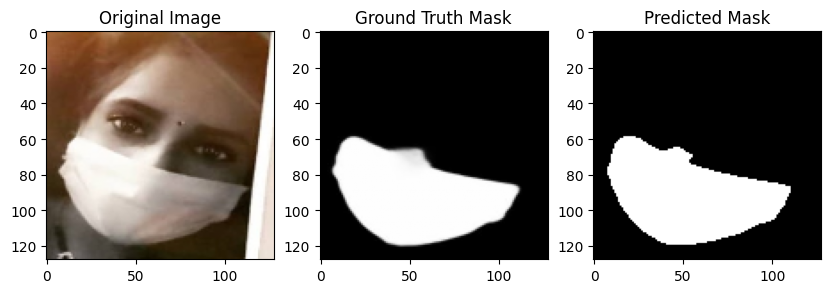

In [ ]:
def predict_sample(model, X_val, Y_val, index=1):
    pred_mask = model.predict(np.expand_dims(X_val[index], axis=0))[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8) 

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[index])
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(Y_val[index].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.show()

predict_sample(model, X_val, Y_val,44)

In [44]:
import numpy as np

def calculate_iou(y_true, y_pred, threshold=0.5):
    # Ensure inputs are binary
    if y_true.dtype != np.bool_:
        y_true = y_true.astype(bool)

    if y_pred.dtype != np.bool_:
        y_pred = (y_pred > threshold).astype(bool)

    # Calculate intersection and union
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    # Handle edge case of empty masks
    if union == 0:
        return 1.0  # Both masks are empty, perfect match

    return intersection / union

def calculate_dice(y_true, y_pred, threshold=0.5):
    # Ensure inputs are binary
    if y_true.dtype != np.bool_:
        y_true = y_true.astype(bool)

    if y_pred.dtype != np.bool_:
        y_pred = (y_pred > threshold).astype(bool)

    # Calculate dice coefficient: 2*|X∩Y|/(|X|+|Y|)
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()

    # Handle edge case of empty masks
    if total == 0:
        return 1.0  # Both masks are empty, perfect match

    return 2 * intersection / total

# Predict on validation set
y_preds = model.predict(X_val)

# Compute IoU for each image
iou_scores = []
dice_scores = []
for i in range(len(Y_val)):
    iou = calculate_iou(Y_val[i], y_preds[i])
    dice = calculate_dice(Y_val[i], y_preds[i])
    iou_scores.append(iou)
    dice_scores.append(dice)
    print(f"Image {i+1}: IoU = {iou:.4f}")
    print(f"Image {i+1}: Dice = {dice:.4f}")

# Compute Mean IoU
mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)
print(f"\nMean IoU on Validation Set: {mean_iou:.4f}")
print(f"\nMean Dice on Validation Set: {mean_dice:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step
Image 1: IoU = 0.9248
Image 1: Dice = 0.9609
Image 2: IoU = 0.9046
Image 2: Dice = 0.9499
Image 3: IoU = 0.6971
Image 3: Dice = 0.8215
Image 4: IoU = 0.8734
Image 4: Dice = 0.9325
Image 5: IoU = 0.9012
Image 5: Dice = 0.9480
Image 6: IoU = 0.8029
Image 6: Dice = 0.8907
Image 7: IoU = 0.8186
Image 7: Dice = 0.9003
Image 8: IoU = 0.7780
Image 8: Dice = 0.8752
Image 9: IoU = 0.9283
Image 9: Dice = 0.9628
Image 10: IoU = 0.8028
Image 10: Dice = 0.8906
Image 11: IoU = 0.8955
Image 11: Dice = 0.9449
Image 12: IoU = 0.9196
Image 12: Dice = 0.9581
Image 13: IoU = 0.8264
Image 13: Dice = 0.9050
Image 14: IoU = 0.9148
Image 14: Dice = 0.9555
Image 15: IoU = 0.9029
Image 15: Dice = 0.9490
Image 16: IoU = 0.7777
Image 16: Dice = 0.8750
Image 17: IoU = 0.8193
Image 17: Dice = 0.9007
Image 18: IoU = 0.6699
Image 18: Dice = 0.8023
Image 19: IoU = 0.7114
Image 19: Dice = 0.8314
Image 20: IoU = 0.9347
Image 20: Dice = 0.9662
Image 21: IoU = 0.8482
Image 21: Dice =